In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import gymnasium as gym 

### 1. Create a DF from OpenBB


In [3]:
from openbb_terminal.sdk import openbb

df = openbb.stocks.load("GOOG")

Forecasting Toolkit is disabled. To use the Forecasting features please install the toolkit following the instructions here: https://docs.openbb.co/sdk/quickstart/installation/

Portfolio Optimization Toolkit is disabled. To use the Optimization features please install the toolkit following the instructions here: https://docs.openbb.co/sdk/quickstart/installation/

Loading Daily data for GOOG with starting period 2020-03-02.

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
date,,,,,,,,
2020-03-02,67.580498,69.543503,66.340752,69.455498,69.455498,48630000,0.0,0.0
2020-03-03,69.971001,70.507500,66.599998,67.069504,67.069504,48046000,0.0,0.0
2020-03-04,67.961502,69.404503,67.155502,69.325996,69.325996,38266000,0.0,0.0
2020-03-05,67.510002,67.945503,65.254997,65.952003,65.952003,51226000,0.0,0.0
2020-03-06,63.853001,65.310997,63.052502,64.920502,64.920502,53212000,0.0,0.0


### 2. Create a TradingEnvironment from DF


In [5]:
import trading_gym as gtr 

# env = gym.make("df-trader-v0")

env = gtr.env.DFTradingEnvironment(
    df = df, 
    window_size = 10,
    frame_bound = (10, 300)
)

In [6]:
print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)
print("> max_possible_profit:", env.reward_strategy.max_possible_profit(env))


env information:
> shape: (10, 2)
> df.shape: (759, 8)
> prices.shape: (300,)
> signal_features.shape: (300, 2)
> max_possible_profit: 12.260367443179785


info: {'total_reward': 27.288681030273438, 'total_profit': 0.4903340631784241, 'position': 1}


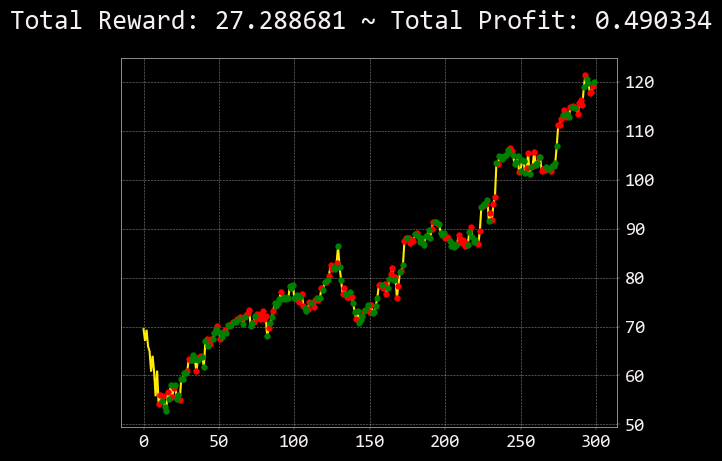

In [7]:
#Example sampling from environemnt import gym

# env = gym.make('stocks-v0', frame_bound=(50, 100), window_size=10)

observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, _, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.render_all()
plt.show()

### 3. Run your RL algo


In [8]:
start_idx = 10 
end_idx = 300 

In [9]:
#! https://github.com/DLR-RM/stable-baselines3/pull/1327


gym.register(
    id="df-trader-v0", 
    entry_point=gtr.env.DFTradingEnvironment,
    kwargs={
        "df" : df, 
        "window_size" : 10,
        "frame_bound" : (start_idx, end_idx)
    }
)

In [10]:
#stable baslines 3 
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env

# env = make_vec_env("df-trader-v0", n_envs=2, vec_env_cls=SubprocVecEnv)
# env = make_vec_env("df-trader-v0", n_envs=1)
model = A2C("MlpPolicy", 'df-trader-v0', device="cpu", verbose=1, )
model.learn(total_timesteps=10000)

# policy_kwargs = dict(net_arch=[64, 'lstm', dict(vf=[128, 128, 128], pi=[64, 64])])
# model = A2C('MlpPolicy', env, verbose=1, policy_kwargs=policy_kwargs)

Using cpu device
Creating environment from the given name 'df-trader-v0'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 289      |
|    ep_rew_mean        | -11      |
| time/                 |          |
|    fps                | 2717     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.677   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 1.39     |
|    value_loss         | 5.36     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 289      |
|    ep_rew_mean        | 9.68     |
| time/                 |          |
|    fps                | 2678     |

### 4. View results


In [11]:
env = gym.make("df-trader-v0")
obs, info = env.reset()
obs.shape

(10, 2)

In [12]:
while True:
    action, _states = model.predict(obs)
    obs, rewards, done, _, info = env.step(action)
    if done:
        print("info:", info)
        break

info: {'total_reward': 21.78498077392578, 'total_profit': 0.4481372997046615, 'position': 0}


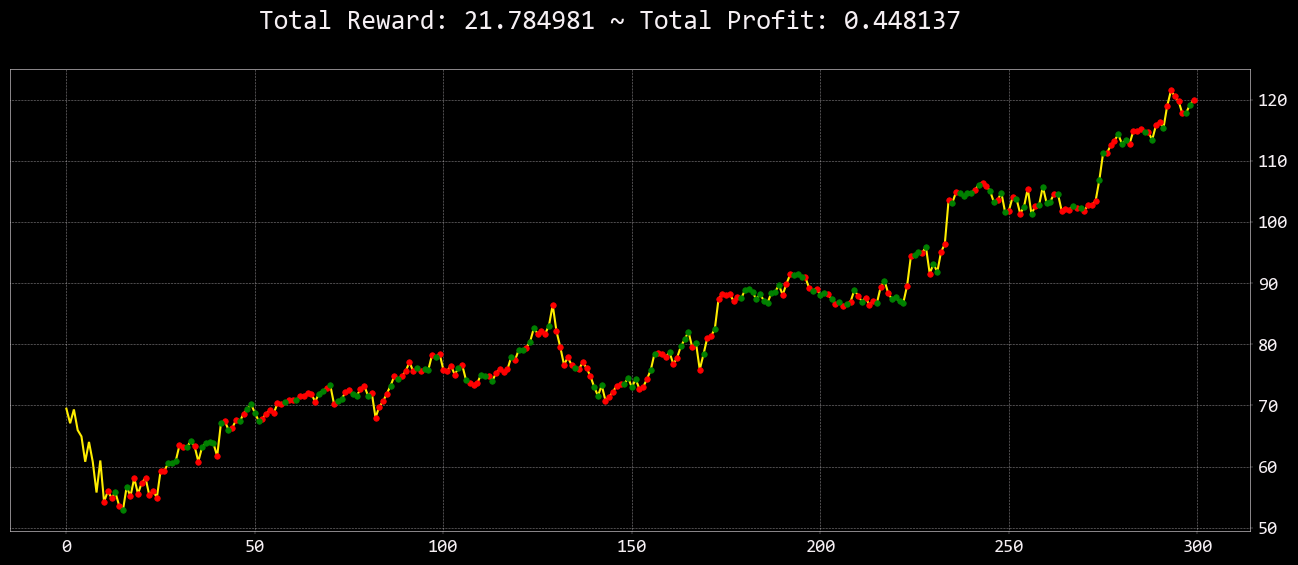

In [13]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()

### Quantstats

                           Strategy
-------------------------  ----------
Start Period               2020-03-18
End Period                 2021-05-07
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          -55.19%
CAGR﹪                     -50.64%

Sharpe                     -3.58
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -3.4
Sortino                    -3.83
Smart Sortino              -3.64
Sortino/√2                 -2.71
Smart Sortino/√2           -2.57
Omega                      0.28

Max Drawdown               -56.5%
Longest DD Days            382
Volatility (ann.)          19.06%
Calmar                     -0.9
Skew                       -2.06
Kurtosis                   9.29

Expected Daily %           -0.28%
Expected Monthly %         -5.21%
Expected Yearly %          -33.06%
Kelly Criterion            -79.71%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.25%
Expected Shortfall (cVaR)  -2.25%

Max Consecutive 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-04-20,2021-04-21,2021-05-07,382,-56.500705,-55.833971
2,2020-03-20,2020-03-20,2020-04-14,25,-5.290208,-2.656046


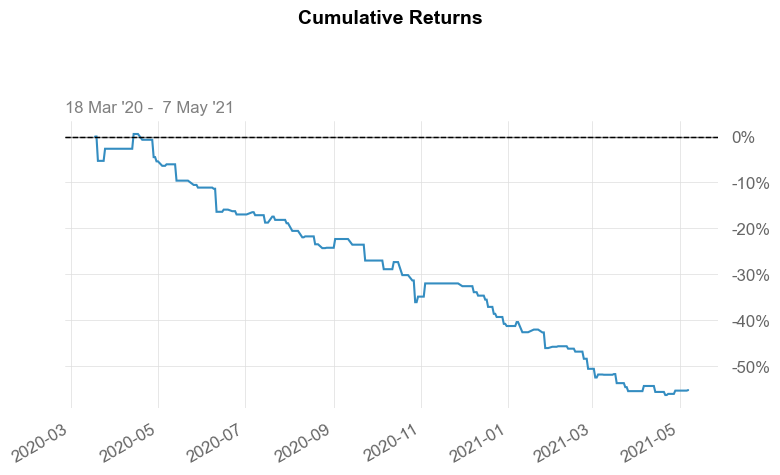

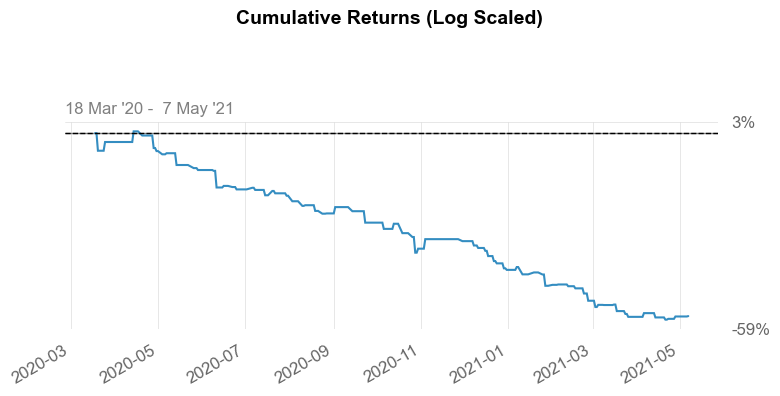

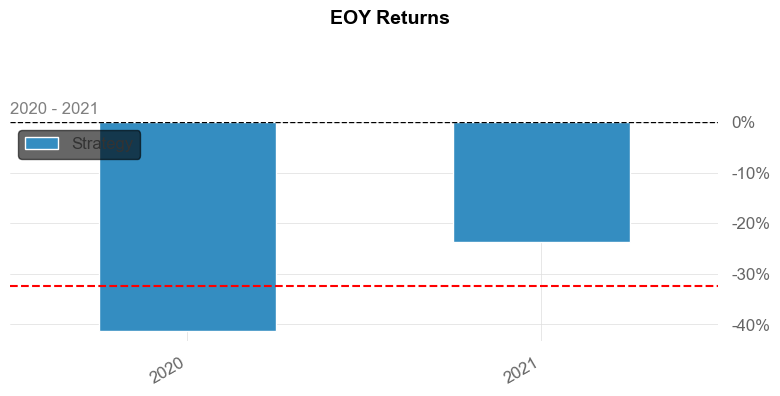

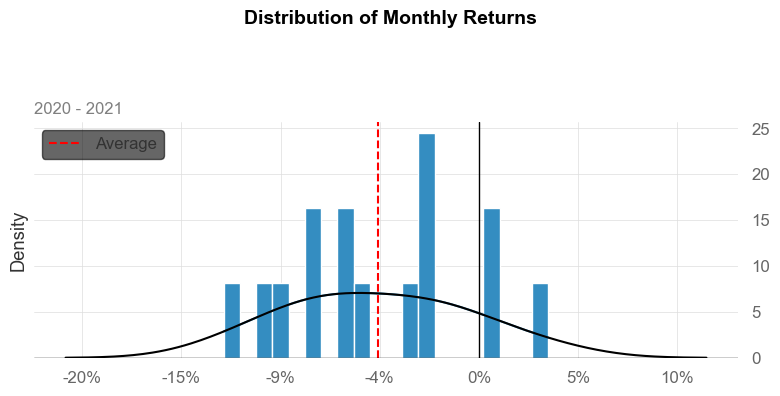

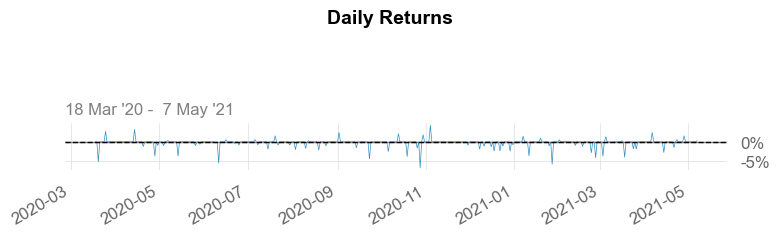

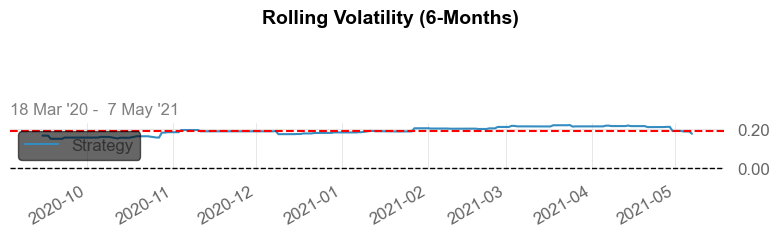

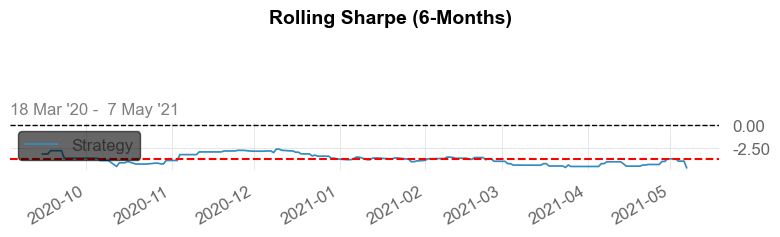

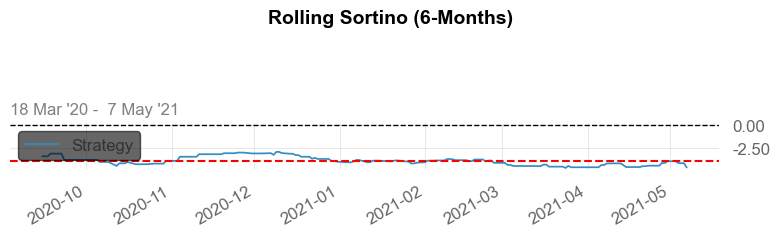

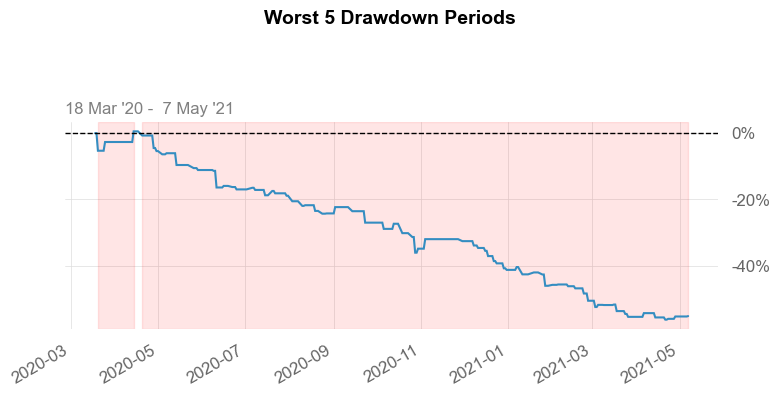

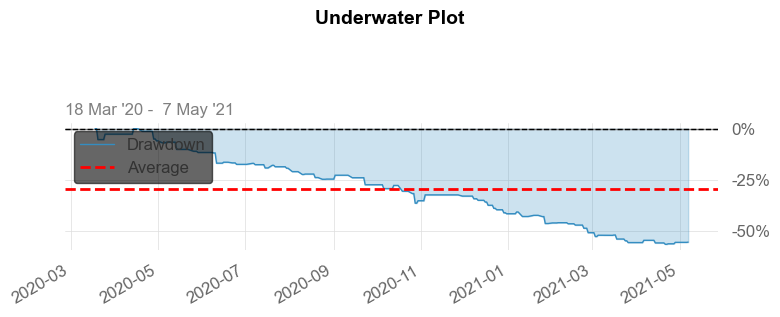

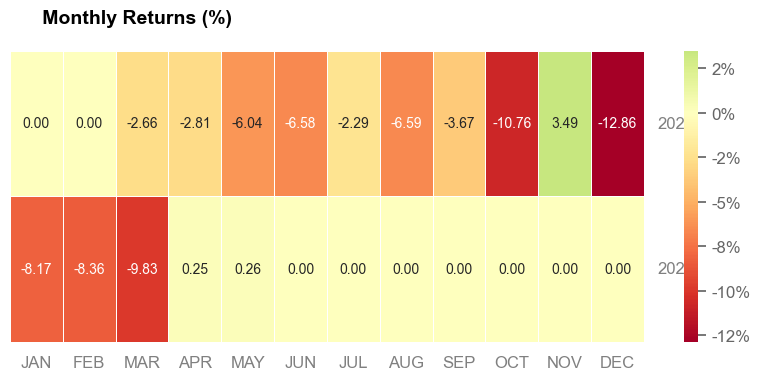

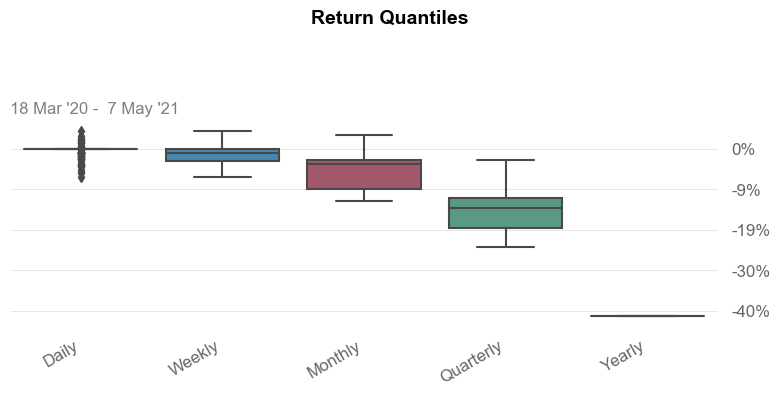

In [15]:
import quantstats as qs

qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[start_idx+1:end_idx])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='a2c_quantstats.html')


### 5. Optuna 